In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 
import wisps.simulations.effective_numbers as eff
import seaborn as sns
import matplotlib
import itertools
#plt.style.use('dark_background')


%matplotlib inline

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database










{'wisps': {'F110': (poly1d([ 1.35701886, 17.88845524]), 0.5704897212579523), 'F140': (poly1d([ 0.62779665, 19.39080278]), 0.5662446812084643), 'F160': (poly1d([ 1.4528292 , 17.14923861]), 1.7686567020674824)}, 'hst3d': {'F110': (None, nan), 'F140': (poly1d([ 0.08327864, 22.19008988]), 0.27183032908753735), 'F160': (poly1d([ 0.35644113, 21.30575276]), 0.30745836180468566)}, 'ncutoff': 60, 'mag_unc_exp': {'F110': array([-3.48259341e-01,  1.43994851e-02,  1.96321758e+01,  2.54117955e-01]), 'F140': array([-0.42977477,  0.11389384, 19.88317909,  0.25976823]), 'F160': array([-0.34825934,  0.11928212, 18.59282532,  0.25131407])}, 'snr_exp': array([-0.2787032

In [2]:
sgrid=wispsim.SPGRID
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

cands=pd.read_pickle(wisps.LIBRARIES+'/real_ucds.pkl')
cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [3]:
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

In [4]:
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [5]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def get_all_numbers():
    #Distribute the parameter sets evenly across the cores
    func=lambda x, y:  get_simulated_number_model(y, x)

    paramlist=[(i, j)  for i, j in itertools.product(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], wispsim.HS)]
    res  = [func(x, y) for x,y in tqdm(paramlist)]
    
    nbrs = {}
    for k in ['saumon2008', 'marley2019', 'phillips2020', 'baraffe2003']:
        ds0={}
        for j in res:
            if k in j.keys():
                key=[x for x in j[k].keys()][0]
                ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
        #print (ds0)
        nbrs[k]=np.array([ds0[k] for k in wispsim.HS])

    return nbrs
    


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]


def iswithin_mag_limits(mags, pnt, spt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] < pnt.mag_limits[k]+ (corr_pols['F110W'][0])(spt))
    return np.logical_or.reduce(flags)

def scale_lf_teff(teffs):
    binedges= np.append(kirkpatrick2020LF['bin_center']-75, kirkpatrick2020LF['bin_center'][-1]-75)
    bools=np.logical_and(teffs <= binedges[-1], teffs >= binedges[0])
    preds=np.histogram(teffs, bins=binedges, normed=False)[0]
    
    obs=np.array(kirkpatrick2020LF['values'])
    unc=np.array(kirkpatrick2020LF['unc'])
    
    obs_monte_carlo= np.random.normal(obs, unc, (1000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
    
    
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    
    #fig, ax=plt.subplots()
    #ax.step(kirkpatrick2020LF['bin_centertw'], preds*scale*(10**-3), where='mid')
    #ax.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
    #         yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3), fmt='o', color='#111111')
    return [np.nanmean(scale), np.nanstd(scale)]

def get_simulated_number_model(hidx, model):
    #hidx is a scale height, model is evolutionary model
    cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    scale=scale_lf_teff(cutdf.teff.values)
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        #print (np.nansum((g[1]).slprob), len(g[1]), scale)
        NSIM[g[0]]=[np.nansum((g[1]).sl*scale[0]), np.nansum((g[1]).sl*scale[1])]
    del cutdf
    return {model: {hidx:NSIM}}


def plot(NUMBERS, VOLUMES, filename='/oberved_numbers.pdf'):
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)

    fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharey=False, sharex=False)
    
    for model, a in zip(['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          label='h={} pc'.format(h), color= cmap(cnorm(h/100)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
        a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
            


    ax[0][1].set_title('Model= SM08', fontsize=18)
    ax[0][0].set_title('Model= B03', fontsize=18)
    ax[1][0].set_title('Model= M19', fontsize=18)
    ax[1][1].set_title('Model= P20', fontsize=18)

    ax[0][0].errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='observations', color='#111111')
    ax[0][0].errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', label='All observations')
    
    ax[0][0].legend(fontsize=14, loc='upper right')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')

In [6]:
#get_simulated_number_model(350, 'saumon2008')

In [7]:
np.ones_like

<function numpy.ones_like(a, dtype=None, order='K', subok=True, shape=None)>

In [8]:
tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')

flags=[iswithin_mag_limits(x, y, z) for x, y, z in zip(obsmgs, tab.pnt.values,tab.spt.values )]

#let's see what happens if we include all objects
#flags=np.ones(len(flags)).astype(bool)
cdf_to_use=tab[flags]

nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)

spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
spgrid3=['Late M', 'L', 'T']

In [9]:
for k in ['F140', 'F110', 'F160']:
    tab['lim_{}'.format(k)]=tab.pnt.apply(lambda x: x.mag_limits[k])
    tab['detected_{}'.format(k)]= tab[k+'W'] < tab['lim_{}'.format(k)]

In [10]:
subtab=(tab[tab.spt.between(30, 35)]).reset_index(drop=True)

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print( subtab[['F140W', 'F160W', 'lim_F140', 'lim_F160', 'detected_F140', 'detected_F160', 'grism_id',
                  'spt']])

       F140W      F160W   lim_F140   lim_F160  detected_F140  detected_F160  \
0        NaN  24.397000  20.868327  21.351540          False          False   
1        NaN  22.726000  21.233123  19.072045          False          False   
2        NaN  24.285000  21.753570  20.351659          False          False   
3  22.706065  23.116423  21.969817  22.750964          False          False   
4  22.552442  22.941506  23.165356  22.468932           True          False   

               grism_id   spt  
0          par468-00163  32.0  
1          par130-00092  34.0  
2          par463-00176  34.0  
3   aegis-03-G141_17053  35.0  
4  goodss-04-G141_17402  35.0  


In [12]:
#NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl')
NUMBERS=get_all_numbers()

100%|██████████| 32/32 [02:29<00:00,  4.68s/it]


In [13]:
#plt.hist(np.log10(NUMBERS['baraffe2003'][0][:,1]))

In [14]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=np.nansum(volumes, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

In [15]:
#tab

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


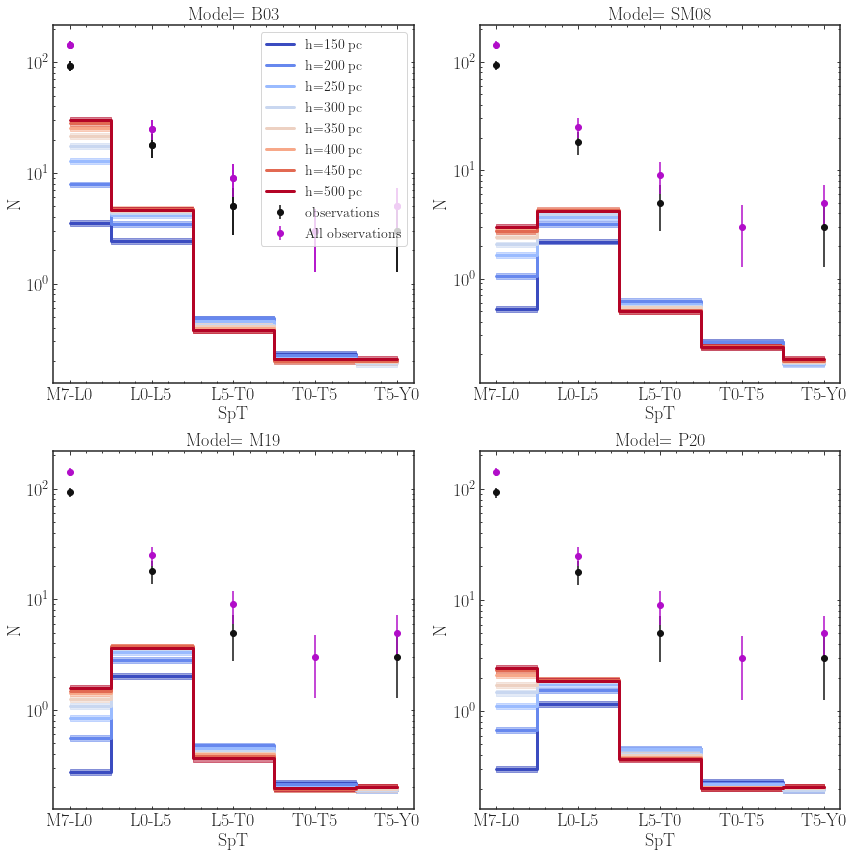

In [16]:
 plot(NUMBERS, VOLUMES, filename='/obs_numbers.pdf')

In [17]:
nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)

In [18]:
y2

[93, 18, 5, 0, 3]

In [19]:
#bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [20]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [1]:
y3

NameError: name 'y3' is not defined

In [22]:
y4=np.append(y2, y3)

In [23]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
        model_fit={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            binned_unc=np.array(bin_by_spt_bin(wispsim.SPGRID,nuncs, ltonly=False))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            #binned_total=np.append(binned, binned_lt)
            #binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})

In [24]:
#chisq_dicts=pd.DataFrame.from_records(best_fit)
number_dicts=pd.DataFrame.from_records(numbers_fit)

In [25]:
from scipy.interpolate import interp1d

In [26]:
len(tab[tab.spt.between(30, 35)])

5

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


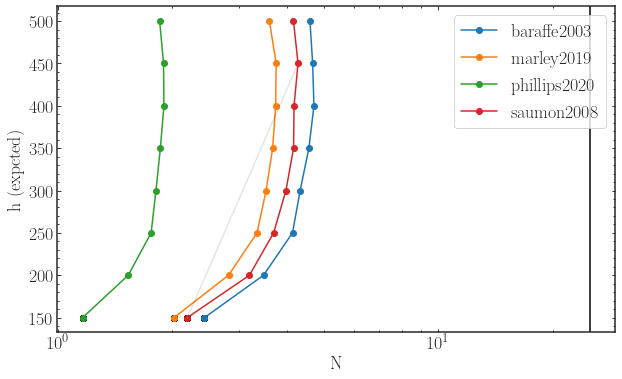

In [27]:
fig, ax=plt.subplots(figsize=(10, 6))
idx=1
for c in number_dicts.columns:
    
    vals=np.vstack([number_dicts[c][h] for h in wispsim.HS])[:,idx]

    interpf = interp1d(vals, wispsim.HS)
    npoisson=np.random.poisson(y3[idx], 100000).astype(float)
    #assign up and down 
    dflag=npoisson>=vals.min()
    uflag= npoisson <=vals.max()
    npoisson[dflag]= vals.min()
    npoisson[uflag]= vals.max()
    predhs=interpf(npoisson)
    sortarray=np.argsort(npoisson)
    plt.plot(  (npoisson)[sortarray], predhs[sortarray],'o-', c='k', alpha=0.1)
    plt.plot(vals, wispsim.HS, 'o-', label=c)
plt.ylabel('h (expcted)', fontsize=18)
plt.xlabel('N', fontsize=18)
plt.xscale('log')
plt.axvline(y3[idx], c='k')
plt.legend()
plt.minorticks_on()

In [28]:
#lt.hist(npoisson)

In [29]:
number_dicts['marley2019'][500]

array([1.58169617, 3.59642784, 0.36328068, 0.19580996, 0.20041056])

In [30]:
min_chi_ssqrs={}
for c in number_dicts.columns:
    min_vals={}
    #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
    for idx,s  in enumerate(spgrid2):
        #compare between subtypes
        #predicted
        vals=(np.vstack(number_dicts[c].values))[:,idx]
        #observed
        nreal= y2[idx]
        #make an interpolation function
        interpf = interp1d(vals, wispsim.HS)
        #using a 2nd degree polynomial 
        
        #draw a bunch of random values based on a poisson distribution
        npoisson=np.random.poisson(nreal, 100000).astype(float)
        #stay within the range of possible values to avoid interpolation error
        #i.e take this as a prior
        #dflag=npoisson>=vals.min()
        #uflag= npoisson <=vals.max()
        #npoisson[dflag]= vals.min()
        #npoisson[uflag]= vals.max()
        npoisson=npoisson[np.logical_and(npoisson>=vals.min(), npoisson <=vals.max())]
        #predict scale heights
        predhs=interpf(npoisson)
        #use a weighted mean and std 
        mean, unc= (np.nanmean(predhs), np.nanstd(predhs))
    
        
        min_vals.update({s:[np.round(mean), np.round(unc, 4)]})
        #final minimal
        print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
        
    min_chi_ssqrs.update({c:min_vals})
    

 scale height for model baraffe2003 and spt M7-L0 is nan +/- nan 
 scale height for model baraffe2003 and spt L0-L5 is 240.0 +/- 0.0 
 scale height for model baraffe2003 and spt L5-T0 is nan +/- nan 
 scale height for model baraffe2003 and spt T0-T5 is nan +/- nan 
 scale height for model baraffe2003 and spt T5-Y0 is nan +/- nan 
 scale height for model marley2019 and spt M7-L0 is nan +/- nan 
 scale height for model marley2019 and spt L0-L5 is nan +/- nan 
 scale height for model marley2019 and spt L5-T0 is nan +/- nan 
 scale height for model marley2019 and spt T0-T5 is nan +/- nan 
 scale height for model marley2019 and spt T5-Y0 is nan +/- nan 
 scale height for model phillips2020 and spt M7-L0 is nan +/- nan 
 scale height for model phillips2020 and spt L0-L5 is nan +/- nan 
 scale height for model phillips2020 and spt L5-T0 is nan +/- nan 
 scale height for model phillips2020 and spt T0-T5 is nan +/- nan 
 scale height for model phillips2020 and spt T5-Y0 is nan +/- nan 
 scale h

In [31]:
pd.DataFrame(min_chi_ssqrs)

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
L0-L5,"[240.0, 0.0]","[nan, nan]","[nan, nan]","[327.0, 0.0]"
L5-T0,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
T0-T5,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
T5-Y0,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"


In [32]:
def propagate_uncertainties(row):
    vals=np.vstack(row.values)[:,0]
    uncs=np.vstack(row.values)[:,1]
    
    return round(np.nanmean(vals)), round(np.sqrt(np.nansum(uncs**2)+ np.nanstd(vals)**2))

In [33]:
pd.DataFrame(min_chi_ssqrs).apply(propagate_uncertainties, axis=1)

M7-L0       (nan, nan)
L0-L5    (284.0, 44.0)
L5-T0       (nan, nan)
T0-T5       (nan, nan)
T5-Y0       (nan, nan)
dtype: object

In [34]:
(376+227)/2

301.5

In [35]:
#use my velocity dispersion converter 
def velocity_dispersion(h, hunc):
    #do a monte carlo uncertainty prop
    hs= np.random.normal(h, hunc, 10000)
    vals=np.sqrt((hs*68)/435*20)

    return np.nanmean(vals), np.nanstd(vals)
    
vel_tables=pd.DataFrame(min_chi_ssqrs).apply(propagate_uncertainties, axis=1).apply(lambda x: velocity_dispersion(x[0], x[1]))

In [36]:
brfvls=pd.DataFrame(min_chi_ssqrs).baraffe2003.iloc[0]

In [37]:
#vel_tables['M7-L0']=velocity_dispersion(brfvls[0], brfvls[1])

In [38]:
#do monte carlo uncertainty propagation
def get_age(sigma, sigmaunc, beta, tau1, sigma10):
    sigmas=np.random.normal(sigma, sigmaunc, 10000)
    vals=((sigmas/sigma10)**(1/beta))*(10+tau1)-tau1
    return np.nanmean(vals), np.nanstd(vals)

In [39]:
age_tables= vel_tables.apply(lambda x: get_age(x[0], x[1], 0.385, 0.261, 57.157))
age_tables=age_tables.apply(lambda x:np.array(x)).apply(lambda x: np.round(x, 1))

In [40]:
age_emp=pd.DataFrame()
age_emp['subtype']=np.array(age_tables.index)
age_emp['age']=np.vstack(age_tables.values)[:,0]
age_emp['unc']=np.vstack(age_tables.values)[:,1]

In [41]:
vel_tables

M7-L0                                  (nan, nan)
L0-L5    (29.707658355929134, 2.3252980838868855)
L5-T0                                  (nan, nan)
T0-T5                                  (nan, nan)
T5-Y0                                  (nan, nan)
dtype: object

In [42]:
age_emp

,subtype,age,unc
0,M7-L0,NaN,NaN
1,L0-L5,1.6,0.4
2,L5-T0,NaN,NaN
3,T0-T5,NaN,NaN
4,T5-Y0,NaN,NaN


In [43]:
def get_simpler_class(x):
    if x.startswith('M'):
        return 'Late M'
    if x.startswith('L'):
        return 'L'
    if x.startswith('T'):
        return 'T'

In [44]:
#plot age with scale heights
age_dictionaries={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    dfs=[]
    for hidx in wispsim.HS:
        dfs.append(pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5',
                               key=str(model)+str('h')+str(hidx)+'F110_corrected'))
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.subtype.apply(get_simpler_class)
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]
    age_dictionaries[model]=final_df

2400953
9746992
2433471
2394116


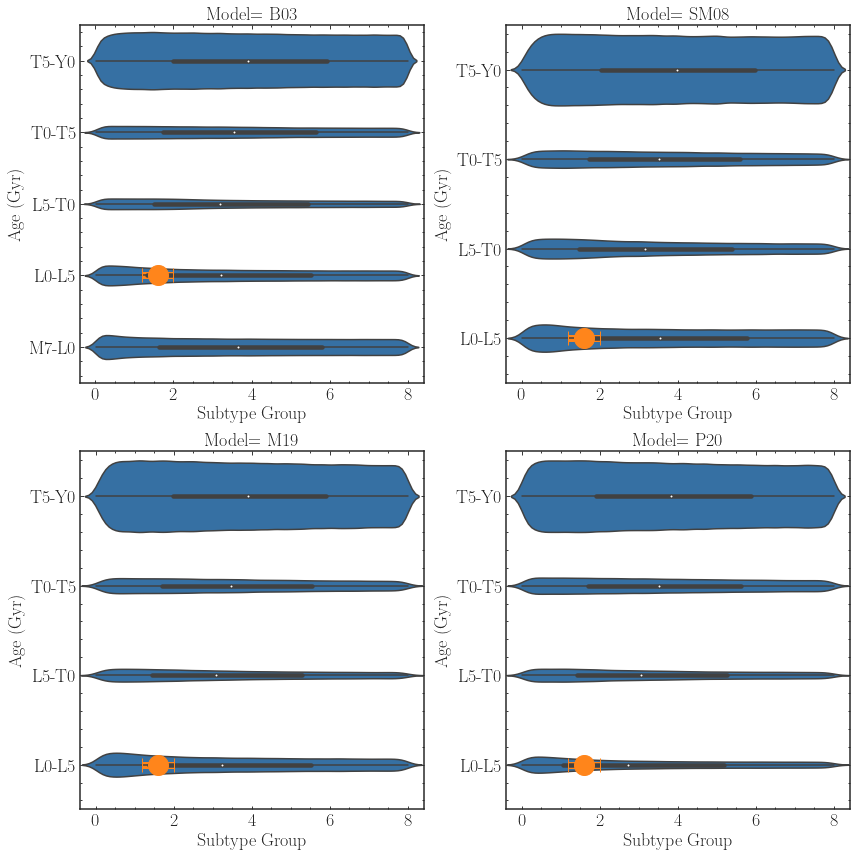

In [45]:

fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharex=False, sharey=False)

for model, a in zip([ 'baraffe2003', 'saumon2008','marley2019', 'phillips2020'], np.concatenate(ax)):
    dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
    
    agfn= age_emp
    #lower limits
    lolims=np.array([0, 0, 0, 0, 1], dtype=bool)
    #upper limits
    uplims =np.array([0, 0, 1, 0, 0], dtype=bool)
    if model !='baraffe2003':
        dfn=dfn[dfn.subtype != 'M7-L0']
        agfn=agfn[agfn.subtype !='M7-L0']
        lolims=np.array([0, 0, 0, 1], dtype=bool)
        uplims =np.array([0, 1, 0, 0], dtype=bool)

        sns.violinplot(x=dfn.age.values, y=dfn.subtype, ax=a,
                    color='#0074D9',  saturation=0.5, scale='count',
                       order=['L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0'])
        a.set_ylim([-0.5, 3.5])
    else:
        sns.violinplot(x=dfn.age.values, y=dfn.subtype, ax=a,
                    color='#0074D9', saturation=0.5, scale='count', order=spgrid2)
        a.set_ylim([-0.5, 4.5])
        
    
    #sns.boxplot(y=dfn.age.values*dfn.slprob, x=dfn.spectclass, ax=a,
    #            color='#FF851B')
    
    #upper and low limit of the error
    #lolims = np.array([0, 0, 0, 0,1], dtype=bool)
   

    a.errorbar(  agfn.age, agfn.subtype, xerr=agfn.unc,  fmt='o',lolims=lolims, ms=20, lw=7, capsize=7, 
               mfc='#FF851B', mec='#FF851B', ecolor='#FF851B', uplims=uplims)
    #a.set_xlim()
    a.set_xlabel('Subtype Group', fontsize=18)
    a.set_ylabel('Age (Gyr)', fontsize=18)
    a.minorticks_on()

ax[0][0].set_title('Model= B03', fontsize=18)
ax[0][1].set_title('Model= SM08', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison.pdf', bbox_inches='tight')


In [46]:
#dfn.appF160.plot(kind='hist', bins=32)

In [47]:
agfn

,subtype,age,unc
1,L0-L5,1.6,0.4
2,L5-T0,NaN,NaN
3,T0-T5,NaN,NaN
4,T5-Y0,NaN,NaN


In [48]:
asjja

NameError: name 'asjja' is not defined